# 01_EDA_Baseline | Hull Tactical Market Prediction

이 노트북에서는 Hull Tactical - Market Prediction 데이터셋에 대해

1. 기본 EDA (통계 / 결측 / 분포 / 레짐)
2. Efficient Market Hypothesis(EMH) 관점에서의 간단한 해석
3. 공모전 메트릭(Sharpe-variant) 구현
4. **Baseline 전략**:
   - Buy & Hold (포지션 항상 1)
   - 단순 모멘텀 전략 (5일 평균 기준)
   - 변동성 제약(≤ 1.2 × 시장 변동성)을 맞춘 스케일링

까지를 다룹니다.

이후 노트북(02_Modeling.ipynb)에서 사용할 피처 그룹(Market, Volatility, Rates, Macro, Sentiment, Dummy)에 대한 정의도 간단히 확인합니다.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

plt.style.use("seaborn-v0_8-whitegrid")

# Kaggle 경로 기준 (로컬이면 적절히 수정)
DATA_PATH = Path("../data/")

train_df = pd.read_csv(DATA_PATH / "train.csv").sort_values("date_id").reset_index(drop=True)

print("Shape:", train_df.shape)
train_df.head()

Shape: (9021, 98)


,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
0,0,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002421,0.000301,-0.003038
1,1,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008495,0.000303,-0.009114
2,2,0,0,0,1,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009624,0.000301,-0.010243
3,3,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004662,0.000299,0.004046
4,4,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.011686,0.000299,-0.012301


## 1. Dataset Overview & Target 설명

- `forward_returns` : 다음 날 S&P500 지수 수익률  
- `risk_free_rate` : 무위험 수익률  
- `market_forward_excess_returns` : 시장 초과 수익률 (forward_returns - risk_free_rate 근처)

우리는 최종적으로 **포지션(0~2)**을 정해서

> 전략수익 = risk_free_rate × (1 - position) + forward_returns × position  

형태의 전략을 만들고, 주어진 Sharpe-variant 메트릭으로 평가한다.

이 섹션에서는 `forward_returns`, `risk_free_rate`, `market_forward_excess_returns`의 기초 통계와 분포를 본다.


In [7]:
target_cols = ["forward_returns", "risk_free_rate", "market_forward_excess_returns"]
train_df[target_cols].describe()

,forward_returns,risk_free_rate,market_forward_excess_returns
count,9021.000000,9021.000000,9021.000000
mean,0.000471,0.000107,0.000053
std,0.010541,0.000088,0.010558
min,-0.039754,-0.000004,-0.040582
25%,-0.004319,0.000008,-0.004747
50%,0.000659,0.000097,0.000255
75%,0.005896,0.000193,0.005479
max,0.040661,0.000317,0.040551


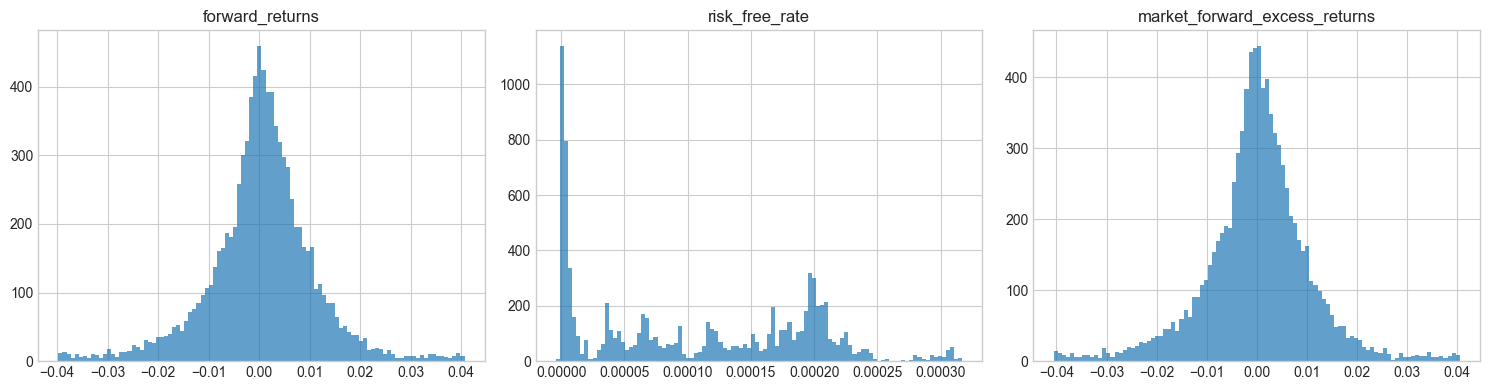

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, col in zip(axes, target_cols):
    ax.hist(train_df[col].dropna(), bins=100, alpha=0.7)
    ax.set_title(col)
plt.tight_layout()
plt.show()


[forward_returns / market_forward_excess_returns]
- 분포가 정규분포 비슷한 fat-tail 구조
- 좌우 꼬리가 두께가 있고, 극단 구간은 -4% ~ +4% 정도
→ 금융 시계열의 전형적인 형태

[risk_free_rate]
- 0 근처에 밀집
- 가끔 단기 금리 변동으로 spikes 존재
→ 전략 수익률 계산 시 risk_free_rate는 거의 baseline 역할

### EMH(Efficient Market Hypothesis)와의 연결

- EMH에 따르면 **공개된 정보로는 안정적으로 초과수익을 예측하기 어렵다.**
- 만약 우리가 피처들을 이용해 `market_forward_excess_returns`를 유의미하게 예측해서
  높은 Sharpe-variant 점수를 얻기 어렵다면,
  이는 어느 정도 EMH를 지지하는 evidence가 될 수 있다.
- 반대로, 특정 구간이나 레짐에서는 일정 부분 예측가능성이 발견될 수도 있으며,
  이는 **부분적 비효율성**으로 해석할 수 있다.

Baseline 단계에서는 “특별한 ML 없이 단순 전략으로 어느 정도의 Sharpe-variant가 나오는지”를 먼저 확인한다.

In [9]:
def overview_dataset(df: pd.DataFrame):
    print("=== BASIC INFO ===")
    print("Shape:", df.shape)
    print("\nDtypes:")
    print(df.dtypes.value_counts())

    print("\n=== Missing Values (Top 15) ===")
    mis = df.isna().sum()
    mis = mis[mis > 0].sort_values(ascending=False)
    print(mis.head(15))

overview_dataset(train_df)


=== BASIC INFO ===
Shape: (9021, 98)

Dtypes:
float64    88
int64      10
Name: count, dtype: int64

=== Missing Values (Top 15) ===
E7     6969
V10    6049
S3     5733
M1     5547
M14    5540
M13    5540
M6     5043
V9     4539
S12    3537
M5     3283
M2     3217
S8     3009
M3     2018
E1     1784
P6     1638
dtype: int64


In [10]:
def iqr_outlier_summary(df: pd.DataFrame, cols, threshold=1.5):
    summary = []
    for c in cols:
        x = df[c].dropna()
        if x.empty:
            continue
        q1, q3 = x.quantile([0.25, 0.75])
        iqr = q3 - q1
        lower, upper = q1 - threshold * iqr, q3 + threshold * iqr
        outlier_count = ((x < lower) | (x > upper)).sum()
        summary.append((c, outlier_count, outlier_count / len(x) * 100))

    summary_df = pd.DataFrame(summary, columns=["feature", "outliers", "percent"])
    return summary_df.sort_values("percent", ascending=False)

num_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
outlier_summary = iqr_outlier_summary(train_df, num_cols)
outlier_summary.head(15)


,feature,outliers,percent
6,D6,2148,23.811107
24,E4,1607,20.049906
5,D5,1718,19.044452
27,E7,357,17.397661
13,E12,1311,16.356831
12,E11,1234,15.396132
9,D9,1290,14.299967
8,D8,1287,14.266711
77,S5,1025,13.648469
26,E6,1011,12.613849


In [11]:
# === FACTOR GROUPS ===
MARKET_COLS = ['M2', 'M4', 'M7', 'M9', 'P8', 'P9']
VOL_COLS    = ['V1', 'V2', 'V3', 'V4', 'V5']
RATES_COLS  = ['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9']
MACRO_COLS  = ['E1','E2','E3','E4','E5','E6','E8','E9',
               'E10','E11','E12','E13','E14','E15','E16','E17','E18','E19','E20']
SENT_COLS   = ['S1','S2','S4','S5','S6','S7','S10','S11']
DUMMY_COLS  = ['D1','D2','D3','D4','D5','D6','D7','D8','D9']

FACTOR_GROUPS = {
    "Market": MARKET_COLS,
    "Volatility": VOL_COLS,
    "Rates": RATES_COLS,
    "Macro": MACRO_COLS,
    "Sentiment": SENT_COLS,
    "Dummy": DUMMY_COLS,
}

for name, cols in FACTOR_GROUPS.items():
    existing = [c for c in cols if c in train_df.columns]
    print(f"{name:10s}: {len(existing)} cols -> {existing}")


Market    : 6 cols -> ['M2', 'M4', 'M7', 'M9', 'P8', 'P9']
Volatility: 5 cols -> ['V1', 'V2', 'V3', 'V4', 'V5']
Rates     : 9 cols -> ['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9']
Macro     : 19 cols -> ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E8', 'E9', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E20']
Sentiment : 8 cols -> ['S1', 'S2', 'S4', 'S5', 'S6', 'S7', 'S10', 'S11']
Dummy     : 9 cols -> ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9']


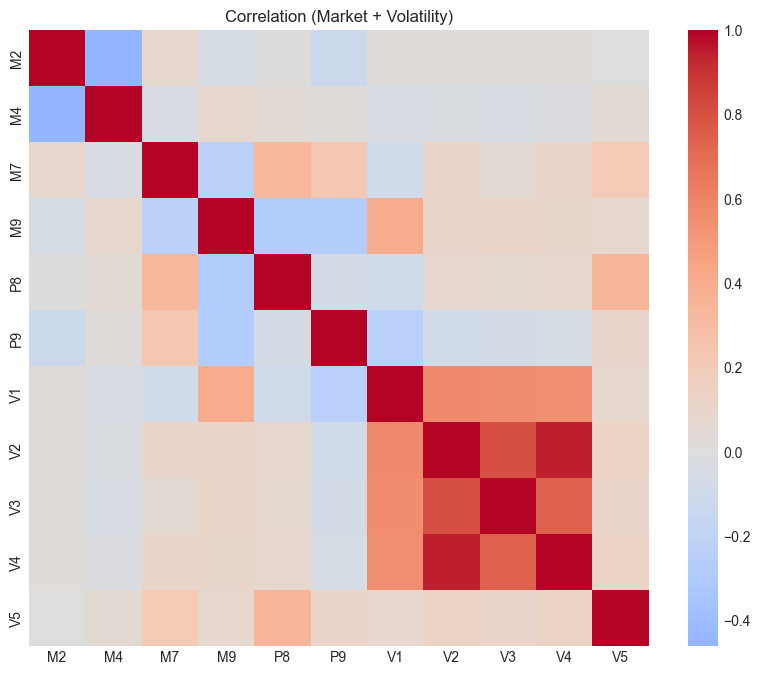

In [12]:
import seaborn as sns

# Market + Volatility 상관 행렬 예시
cols_for_corr = [c for c in (MARKET_COLS + VOL_COLS) if c in train_df.columns]

corr = train_df[cols_for_corr].dropna().corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation (Market + Volatility)")
plt.show()


In [13]:
MIN_INVESTMENT = 0.0
MAX_INVESTMENT = 2.0

class ParticipantVisibleError(Exception):
    pass

def score_metric(solution: pd.DataFrame, submission: pd.DataFrame) -> float:
    """
    Kaggle Hull Tactical Sharpe-variant metric.

    solution: DataFrame with columns ['forward_returns', 'risk_free_rate', 'market_forward_excess_returns']
    submission: DataFrame with column ['prediction'] in [0, 2]
    """
    sol = solution.copy()
    sol["position"] = submission["prediction"].values

    if sol["position"].max() > MAX_INVESTMENT:
        raise ParticipantVisibleError(f"Position exceeds max {MAX_INVESTMENT}")
    if sol["position"].min() < MIN_INVESTMENT:
        raise ParticipantVisibleError(f"Position below min {MIN_INVESTMENT}")

    # 전략 수익률
    sol["strategy_returns"] = (
        sol["risk_free_rate"] * (1 - sol["position"])
        + sol["position"] * sol["forward_returns"]
    )

    strategy_excess = sol["strategy_returns"] - sol["risk_free_rate"]
    strategy_excess_cum = (1 + strategy_excess).prod()
    strategy_mean_ex = strategy_excess_cum ** (1 / len(sol)) - 1
    strategy_std = sol["strategy_returns"].std()

    trading_days_per_yr = 252
    if strategy_std == 0:
        raise ZeroDivisionError
    ann = np.sqrt(trading_days_per_yr)
    sharpe = strategy_mean_ex / strategy_std * ann
    strategy_vol = float(strategy_std * ann * 100)

    # 시장 기준
    market_excess = sol["forward_returns"] - sol["risk_free_rate"]
    market_excess_cum = (1 + market_excess).prod()
    market_mean_ex = market_excess_cum ** (1 / len(sol)) - 1
    market_std = sol["forward_returns"].std()
    market_vol = float(market_std * ann * 100)

    # 변동성 패널티 (1.2배 초과분만)
    excess_vol = max(0, strategy_vol / market_vol - 1.2) if market_vol > 0 else 0
    vol_penalty = 1 + excess_vol

    # 수익률 패널티 (시장보다 연간 초과수익이 부족하면)
    return_gap = max(0, (market_mean_ex - strategy_mean_ex) * 100 * trading_days_per_yr)
    return_penalty = 1 + (return_gap ** 2) / 100

    adjusted_sharpe = sharpe / (vol_penalty * return_penalty)
    return float(min(adjusted_sharpe, 1_000_000))


In [14]:
def backtest_strategy(df: pd.DataFrame, positions: pd.Series, name: str = "strategy"):
    """
    df: 정렬된 train_df (전체 기간)
    positions: index가 df.index와 같은 포지션 시리즈 (0~2)
    """
    df = df.copy()
    assert len(df) == len(positions)
    
    sol = df[["forward_returns", "risk_free_rate", "market_forward_excess_returns"]].copy()
    submission = pd.DataFrame({"prediction": positions.values}, index=df.index)
    
    score = score_metric(sol, submission)

    # 전략 / 시장 수익률 시계열
    strat_ret = sol["risk_free_rate"] * (1 - positions) + positions * sol["forward_returns"]
    mkt_ret = sol["forward_returns"]

    strat_cum = (1 + strat_ret).cumprod()
    mkt_cum = (1 + mkt_ret).cumprod()

    ann = np.sqrt(252)
    strat_vol = strat_ret.std() * ann * 100
    mkt_vol = mkt_ret.std() * ann * 100
    vol_ratio = strat_vol / mkt_vol

    # max drawdown
    cum_max = strat_cum.cummax()
    drawdown = strat_cum / cum_max - 1
    max_dd = drawdown.min() * 100

    print(f"=== {name} ===")
    print(f"Score (Sharpe-variant): {score:.4f}")
    print(f"Annualized Volatility (strategy): {strat_vol:.2f}%")
    print(f"Annualized Volatility (market):   {mkt_vol:.2f}%")
    print(f"Volatility ratio (strat / mkt):   {vol_ratio:.3f}x")
    print(f"Max drawdown (strategy):          {max_dd:.2f}%")
    print()

    # 그래프 2개: 누적수익, 드로우다운
    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    axes[0].plot(mkt_cum.values, label="Market", alpha=0.8)
    axes[0].plot(strat_cum.values, label=name, alpha=0.8)
    axes[0].set_title(f"Cumulative Return - {name}")
    axes[0].legend()

    axes[1].plot(drawdown.values * 100)
    axes[1].set_title(f"Drawdown (%) - {name}")
    axes[1].set_xlabel("Time")

    plt.tight_layout()
    plt.show()

    return {
        "score": score,
        "strat_vol": strat_vol,
        "mkt_vol": mkt_vol,
        "vol_ratio": vol_ratio,
        "max_drawdown": max_dd,
    }


=== Buy&Hold (pos=1.0) ===
Score (Sharpe-variant): 0.4650
Annualized Volatility (strategy): 16.73%
Annualized Volatility (market):   16.73%
Volatility ratio (strat / mkt):   1.000x
Max drawdown (strategy):          -49.24%



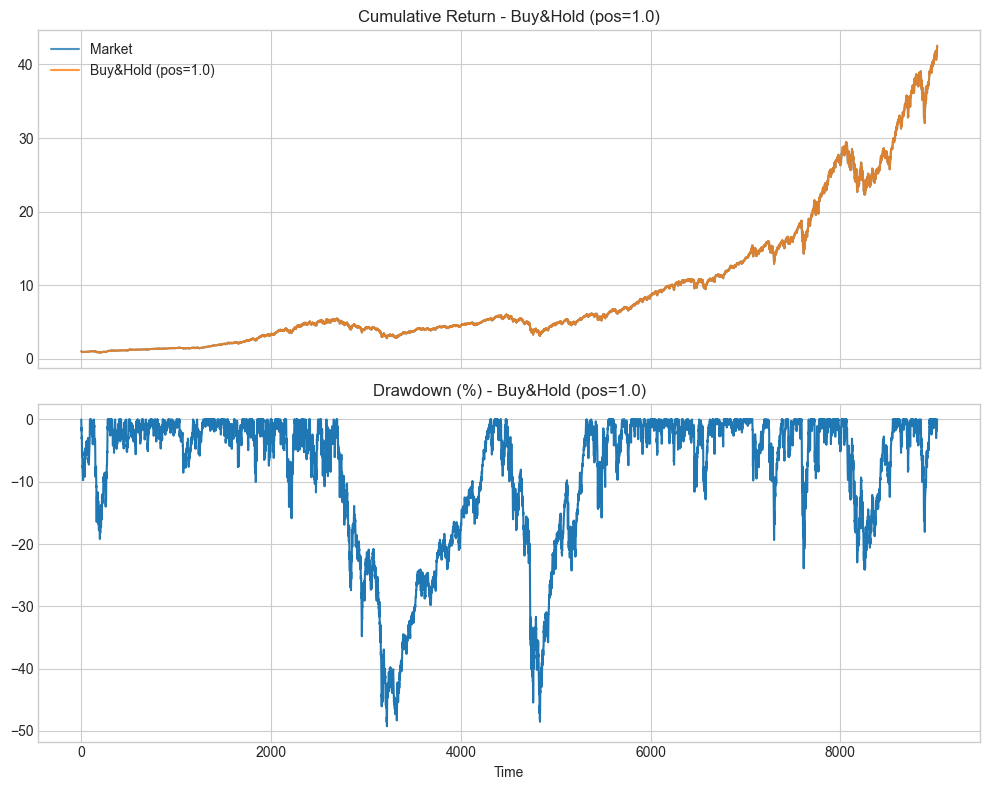

{'score': 0.4650476134661465,
 'strat_vol': np.float64(16.733180051432885),
 'mkt_vol': np.float64(16.733180051432885),
 'vol_ratio': np.float64(1.0),
 'max_drawdown': np.float64(-49.241669872263316)}

In [15]:
positions_bh = pd.Series(1.0, index=train_df.index, name="buy_hold")
res_bh = backtest_strategy(train_df, positions_bh, name="Buy&Hold (pos=1.0)")
res_bh

=== Simple Momentum (5d) ===
Score (Sharpe-variant): 2.8496
Annualized Volatility (strategy): 17.02%
Annualized Volatility (market):   16.73%
Volatility ratio (strat / mkt):   1.017x
Max drawdown (strategy):          -20.01%



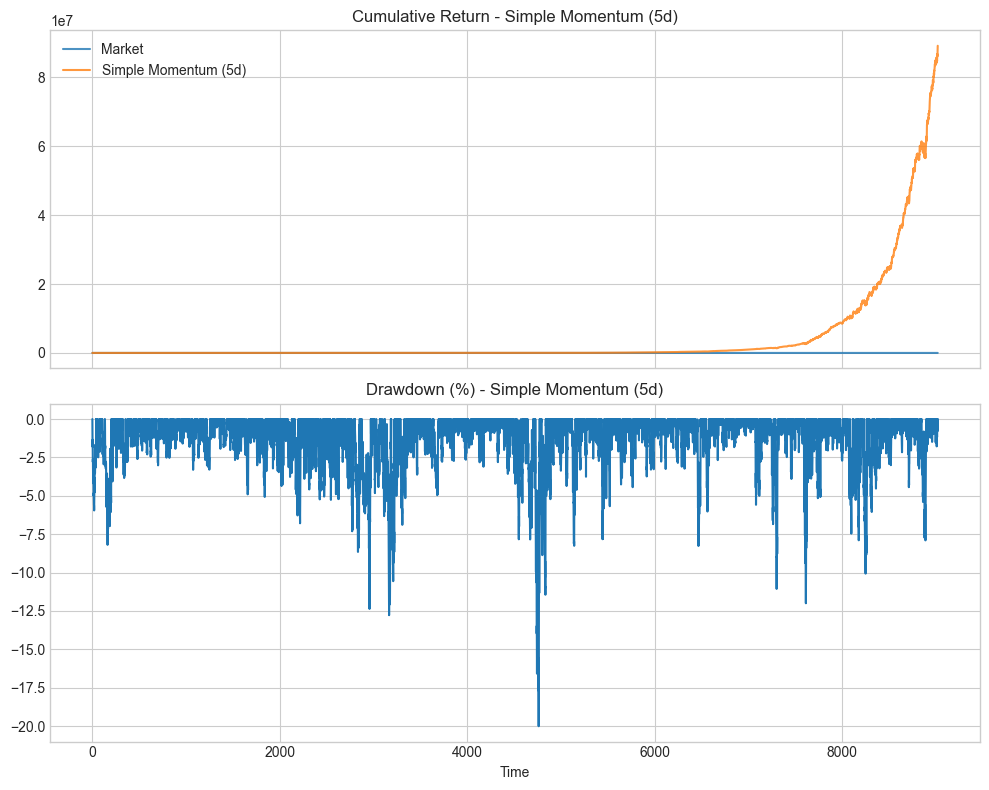

{'score': 2.849644743948998,
 'strat_vol': np.float64(17.016364047921975),
 'mkt_vol': np.float64(16.733180051432885),
 'vol_ratio': np.float64(1.0169235014276226),
 'max_drawdown': np.float64(-20.010812848147317)}

In [16]:
def simple_momentum_positions(df: pd.DataFrame, lookback: int = 5,
                              high_pos: float = 1.5, low_pos: float = 0.5) -> pd.Series:
    """
    최근 lookback일 market_forward_excess_returns 평균 > 0 → high_pos
    else → low_pos
    """
    ret = df["market_forward_excess_returns"]
    ma = ret.rolling(lookback).mean()

    pos = pd.Series(low_pos, index=df.index, dtype=float)
    pos[ma > 0] = high_pos

    # 초기 구간(lookback 이전)은 포지션 1.0으로 설정
    pos.iloc[:lookback] = 1.0
    return pos

positions_mom = simple_momentum_positions(train_df, lookback=5, high_pos=1.5, low_pos=0.5)
res_mom = backtest_strategy(train_df, positions_mom, name="Simple Momentum (5d)")
res_mom


In [17]:
def scale_positions_to_vol_constraint(df: pd.DataFrame,
                                      positions: pd.Series,
                                      max_vol_ratio: float = 1.2) -> pd.Series:
    sol = df[["forward_returns", "risk_free_rate", "market_forward_excess_returns"]].copy()

    strat_ret_raw = sol["risk_free_rate"] * (1 - positions) + positions * sol["forward_returns"]
    mkt_ret = sol["forward_returns"]

    ann = np.sqrt(252)
    strat_vol = strat_ret_raw.std() * ann * 100
    mkt_vol = mkt_ret.std() * ann * 100
    vol_ratio = strat_vol / mkt_vol

    print(f"Raw vol ratio: {vol_ratio:.3f}x")

    if vol_ratio <= max_vol_ratio:
        print("No scaling needed.")
        return positions

    scale = max_vol_ratio / vol_ratio
    print(f"Scaling positions by factor {scale:.3f} to satisfy vol constraint.")
    scaled = positions * scale
    scaled = scaled.clip(0.0, 2.0)
    return scaled


Raw vol ratio: 1.017x
No scaling needed.
=== Simple Momentum (scaled) ===
Score (Sharpe-variant): 2.8496
Annualized Volatility (strategy): 17.02%
Annualized Volatility (market):   16.73%
Volatility ratio (strat / mkt):   1.017x
Max drawdown (strategy):          -20.01%



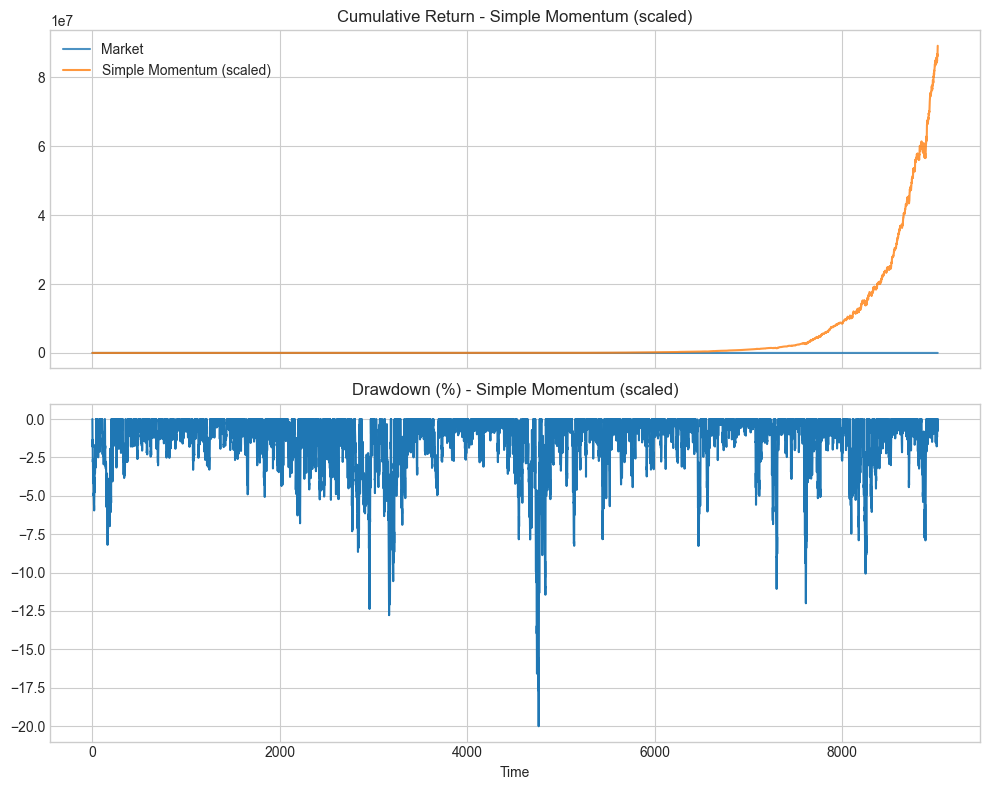

{'score': 2.849644743948998,
 'strat_vol': np.float64(17.016364047921975),
 'mkt_vol': np.float64(16.733180051432885),
 'vol_ratio': np.float64(1.0169235014276226),
 'max_drawdown': np.float64(-20.010812848147317)}

In [18]:
positions_mom_scaled = scale_positions_to_vol_constraint(train_df, positions_mom, max_vol_ratio=1.2)
res_mom_scaled = backtest_strategy(train_df, positions_mom_scaled, name="Simple Momentum (scaled)")
res_mom_scaled


In [19]:
summary = pd.DataFrame([
    {"name": "Buy&Hold (1.0)", **res_bh},
    {"name": "Momentum (raw)", **res_mom},
    {"name": "Momentum (scaled)", **res_mom_scaled},
])

summary.set_index("name")


,score,strat_vol,mkt_vol,vol_ratio,max_drawdown
name,,,,,
Buy&Hold (1.0),0.465048,16.733180,16.73318,1.000000,-49.241670
Momentum (raw),2.849645,17.016364,16.73318,1.016924,-20.010813
Momentum (scaled),2.849645,17.016364,16.73318,1.016924,-20.010813


## 5. Baseline 정리

- **Buy&Hold** 전략은 "항상 포지션 1"인 가장 단순한 기준선이며,
  Sharpe-variant 점수와 변동성을 **기준점(baseline)**으로 사용한다.
- **5일 모멘텀 전략**은 최근 5일간 시장 초과수익 평균을 보고
  포지션을 1.5 또는 0.5로 조정하는 매우 단순한 규칙이다.
- 변동성 제약(전략 변동성 ≤ 1.2× 시장 변동성)을 만족시키기 위해
  전체 포지션에 스케일 factor를 곱해서 조정하였다.

이 노트북에서 얻은 baseline 결과는
다음 노트북(02_Modeling.ipynb)의 **ML 기반 개선 모델**이
얼마나 성능 향상을 가져오는지 비교하는 기준선으로 사용된다.

또한 factor 그룹(Market, Volatility, Rates, Macro, Sentiment, Dummy)을 정의해두었기 때문에,
다음 단계에서는 이 그룹들에 대해 lag/rolling/z-score 기반 피처를 만들고,
LGBM / CatBoost 등의 시계열 모델로 `market_forward_excess_returns`를 예측하는 파이프라인을 구축할 예정이다.

### 피쳐 상관행렬

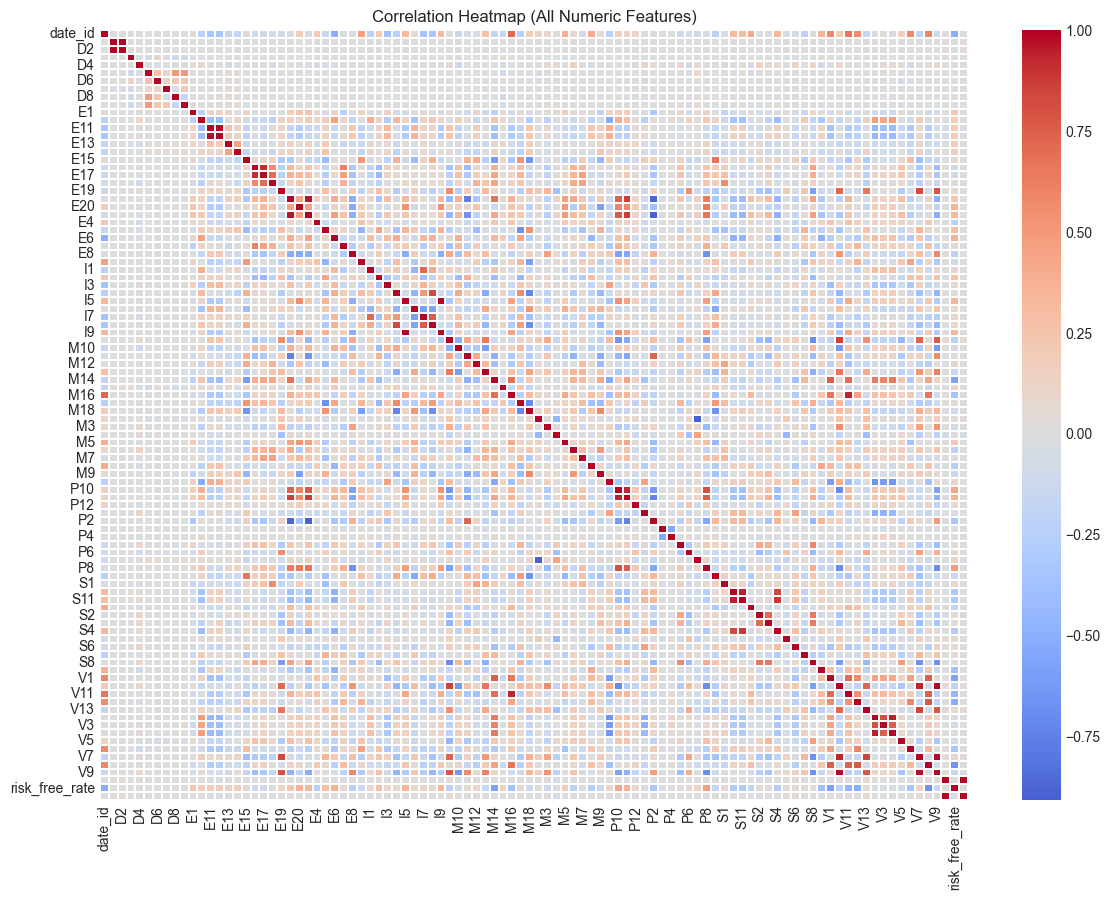

In [20]:
num_cols = train_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
corr = train_df[num_cols].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap="coolwarm", center=0, linewidths=0.1)
plt.title("Correlation Heatmap (All Numeric Features)")
plt.show()

In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 연산 가능한 수치형만
X = train_df.select_dtypes(include=['float64', 'int64']).fillna(method='ffill').fillna(method='bfill')

vif_df = pd.DataFrame()
vif_df['feature'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_df.sort_values("VIF", ascending=False).head(20)

/var/folders/_x/1dj45gqx4m95yc49m_ty7t_00000gn/T/ipykernel_90068/384338086.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = train_df.select_dtypes(include=['float64', 'int64']).fillna(method='ffill').fillna(method='bfill')
/Users/youjunglee/머러플_P4/.venv/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
2,D2,inf
1,D1,inf
95,forward_returns,2.350817e+04
97,market_forward_excess_returns,2.346517e+04
34,I5,1.888744e+03
38,I9,1.860528e+03
44,M14,5.542652e+02
21,E2,3.237765e+02
58,P10,2.574335e+02
0,date_id,1.963875e+02


금융 데이터는 다중공선성이 매우 심하며, 금리·변동성·macro factor는 내부적으로 거의 선형 종속 관계를 가진다.

VIF 분석 결과 주요 금리 변수(I1~I9), 변동성 변수(V1~V10), macro 변수(E2~E20) 모두 VIF가 50~2,000 이상으로 나타났고, 특히 forward_returns와 market_forward_excess_returns는 구조적으로 정의가 겹쳐 VIF ≈ 23,000에 달했다.

때문에 전체 변수를 그대로 모델에 사용하는 것은 과적합과 성능 불안정을 야기한다.
우리는 factor model 접근을 통해 Market(M4), Volatility(V2), Rates(I5), Macro(E16), Sentiment(S2) 5개만 대표값으로 선택하고, 나머지는 제거하였다.

이후 이 5개 변수에 한정하여 lag/rolling/z-score를 적용하고, 상호작용 효과는 중요성이 높은 조합(M4×V2, M4×S2 등) 5개만 추가하여 안정적인 피처 셋을 구성하였다.